In [50]:
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [51]:
print(tf.config.list_physical_devices('CPU'))

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [52]:
training_set = tf.keras.utils.image_dataset_from_directory(
    'train',
    labels="inferred",
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 3115 files belonging to 36 classes.


In [53]:
!nvidia-smi

Wed Jan  1 17:12:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.76                 Driver Version: 560.76         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Quadro P3200                 WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   52C    P8              9W /   70W |    5017MiB /   6144MiB |     19%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [54]:

validation_set = tf.keras.utils.image_dataset_from_directory(
    'validation',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 351 files belonging to 36 classes.


In [55]:
cnn = tf.keras.models.Sequential()


In [56]:
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[64,64,3]))
cnn.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

# Lớp Conv2D:

+ filters=32: Số lượng “kênh đầu ra” (hay số kernel/filter) là 32. Mỗi kernel sẽ học một đặc trưng khác nhau từ ảnh.
+ kernel_size=3: Kích thước của kernel (hay “cửa sổ lọc”) là 3×3.
+ padding='same': Kích thước đầu ra theo chiều rộng, chiều cao sẽ được giữ nguyên so với đầu vào (64x64). Điều này có nghĩa là Keras sẽ tự động thêm 0-padding xung quanh nếu cần, để đảm bảo kích thước không đổi.
+ activation='relu': Hàm kích hoạt ReLU (Rectified Linear Unit) giúp mạng học được các đặc trưng phi tuyến, ngăn gradient mất mát khi lan truyền ngược và hoạt động tốt trong hầu hết các mô hình CNN.
+ input_shape=[64,64,3]: Kích thước đầu vào của ảnh. Ảnh có chiều rộng 64, chiều cao 64 và 3 kênh màu (RGB).

Tóm lại, lớp Conv2D này có nhiệm vụ quét qua ảnh đầu vào (hoặc đầu ra của lớp trước, nếu có) để tìm các đặc trưng như đường biên, góc cạnh, chi tiết,... Số filters càng lớn thì mạng học được càng nhiều loại đặc trưng khác nhau, nhưng đồng thời cũng tốn tài nguyên tính toán hơn.



# Lớp Conv2D tiếp theo:

+ filters=32: Tiếp tục sử dụng 32 filters. 
+ kernel_size=3: Vẫn là kích thước 3×3. 
+ activation='relu': Sử dụng cùng hàm kích hoạt ReLU.

Lớp này nối tiếp lớp Conv2D trước đó, giúp mạng học thêm những đặc trưng phức tạp hơn. Lưu ý ở lớp này không có tham số padding='same', nếu không được chỉ rõ thì mặc định là padding='valid' (trong Keras), dẫn đến kích thước đầu ra sau phép tích chập có thể bị giảm bớt một ít so với đầu vào (tuỳ theo cấu hình).

# Lớp Max Pooling:

+ pool_size=2: Kích thước cửa sổ pooling là 2×2. 
Điều này có nghĩa là chúng ta lấy giá trị lớn nhất của từng vùng 2×2 trong ma trận đặc trưng.
+ strides=2: “Bước nhảy” = 2, tức là sau mỗi lần lấy giá trị lớn nhất của vùng 2×2, cửa sổ lại nhảy tiếp 2 pixel sang bên (hoặc xuống dưới) để lấy vùng kế tiếp. Việc này làm giảm một nửa chiều rộng và chiều cao của feature map.

Mục đích của Max Pooling là giảm kích thước không gian (spatial dimension) của đặc trưng, đồng thời giữ lại thông tin quan trọng nhất (giá trị lớn nhất). Kỹ thuật này giúp giảm số lượng tham số, giảm hiện tượng overfitting, tăng tốc độ huấn luyện và vẫn giữ được những đặc trưng quan trọng trong ảnh.

# Dropout
Dropout trong mạng CNN (Convolutional Neural Network) là một kỹ thuật regularization (chống overfitting) được giới thiệu nhằm giảm thiểu tình trạng mạng học “quá khớp” (overfit) với dữ liệu huấn luyện.

Cụ thể, trong quá trình huấn luyện, Dropout sẽ ngẫu nhiên “tắt bớt” một số nơ-ron (tức là đưa các đầu ra của chúng về 0) ở một lớp nhất định với một xác suất p nào đó (ví dụ: 0.2, 0.3,...). Mục đích chính của việc này là:

Giảm sự phụ thuộc lẫn nhau giữa các nơ-ron: Khi một số nơ-ron bị loại bỏ ngẫu nhiên, mạng buộc phải dựa trên nhiều đặc trưng khác nhau thay vì quá phụ thuộc vào một nhóm nơ-ron nhất định.

Tăng tính khái quát: Mạng sẽ học được nhiều mẫu (pattern) tổng quát hơn, giúp mô hình có khả năng dự đoán tốt trên dữ liệu mới thay vì chỉ nhớ máy móc dữ liệu huấn luyện.

Sau khi huấn luyện (ở bước suy luận - inference), chúng ta thường tắt Dropout (nghĩa là không áp dụng việc tắt nơ-ron ngẫu nhiên nữa) và sử dụng đầy đủ tất cả các tham số của mạng để dự báo kết quả.

In [57]:
cnn.add(tf.keras.layers.Dropout(0.25))

In [58]:
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
cnn.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

In [59]:
cnn.add(tf.keras.layers.Dropout(0.25))

In [60]:
cnn.add(tf.keras.layers.Flatten())

In [61]:
cnn.add(tf.keras.layers.Dense(units=512,activation='relu'))


In [62]:
cnn.add(tf.keras.layers.Dense(units=256,activation='relu'))

In [63]:
cnn.add(tf.keras.layers.Dropout(0.5)) #To avoid overfitting

In [64]:

#Output Layer
cnn.add(tf.keras.layers.Dense(units=36,activation='softmax'))

compiling

In [65]:
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [66]:

cnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 conv2d_11 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 31, 31, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 31, 31, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 64)        36928     
                                                      

In [67]:
training_history = cnn.fit(x=training_set,validation_data=validation_set,epochs=32)

Epoch 1/32
98/98 [==============================] - 32s 264ms/step - loss: 6.2424 - accuracy: 0.0305 - val_loss: 3.5680 - val_accuracy: 0.0513
Epoch 2/32
98/98 [==============================] - 27s 251ms/step - loss: 3.5495 - accuracy: 0.0417 - val_loss: 3.5135 - val_accuracy: 0.0769
Epoch 3/32
98/98 [==============================] - 27s 252ms/step - loss: 3.4407 - accuracy: 0.0623 - val_loss: 3.2284 - val_accuracy: 0.0997
Epoch 4/32
98/98 [==============================] - 27s 258ms/step - loss: 3.3002 - accuracy: 0.0735 - val_loss: 2.9436 - val_accuracy: 0.1823
Epoch 5/32
98/98 [==============================] - 27s 254ms/step - loss: 3.1290 - accuracy: 0.1043 - val_loss: 2.9146 - val_accuracy: 0.1624
Epoch 6/32
98/98 [==============================] - 27s 250ms/step - loss: 2.9812 - accuracy: 0.1493 - val_loss: 2.3622 - val_accuracy: 0.3647
Epoch 7/32
98/98 [==============================] - 27s 256ms/step - loss: 2.8662 - accuracy: 0.1772 - val_loss: 2.3468 - val_accuracy: 0.3903

# Evaluating Model

In [68]:

#Training set Accuracy
train_loss, train_acc = cnn.evaluate(training_set)
print('Training accuracy:', train_acc)

98/98 [==============================] - 23s 215ms/step - loss: 0.2510 - accuracy: 0.9348
Training accuracy: 0.934831440448761


In [69]:

#Validation set Accuracy
val_loss, val_acc = cnn.evaluate(validation_set)
print('Validation accuracy:', val_acc)

11/11 [==============================] - 4s 67ms/step - loss: 0.5296 - accuracy: 0.9202
Validation accuracy: 0.9202279448509216


In [70]:
cnn.save('trained_model.h5')

In [71]:

training_history.history #Return Dictionary of history

{'loss': [6.24244499206543,
  3.5495166778564453,
  3.440657377243042,
  3.3001773357391357,
  3.1290338039398193,
  2.981243133544922,
  2.8661773204803467,
  2.660614490509033,
  2.5337321758270264,
  2.2963287830352783,
  2.1289258003234863,
  1.9200626611709595,
  1.7638452053070068,
  1.675062894821167,
  1.508131980895996,
  1.377238392829895,
  1.3542335033416748,
  1.1856356859207153,
  1.1277565956115723,
  1.0512036085128784,
  0.9925603866577148,
  0.895747721195221,
  0.8352136015892029,
  0.8781185746192932,
  0.7871875762939453,
  0.7136225700378418,
  0.6468175649642944,
  0.648862898349762,
  0.63238126039505,
  0.5687386393547058,
  0.5581143498420715,
  0.46636587381362915],
 'accuracy': [0.030497591942548752,
  0.041733548045158386,
  0.062279295176267624,
  0.07351525127887726,
  0.10433387011289597,
  0.1492776870727539,
  0.1772070676088333,
  0.23242375254631042,
  0.27415731549263,
  0.3280898928642273,
  0.38523274660110474,
  0.433065801858902,
  0.47319421172

In [73]:

#Recording History in json
import json
with open('training_hist.json','w') as f:
  json.dump(training_history.history,f)

In [74]:

print(training_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [75]:
print("Validation set Accuracy: {} %".format(training_history.history['val_accuracy'][-1]*100))


Validation set Accuracy: 92.02279448509216 %


# Accuracy Visualization

Training Visualization

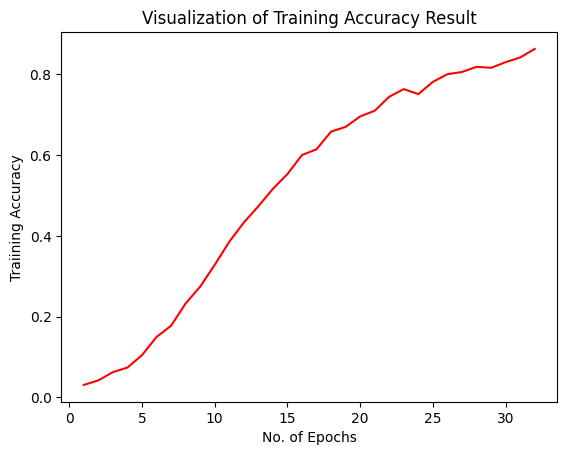

In [76]:

epochs = [i for i in range(1,33)]
plt.plot(epochs,training_history.history['accuracy'],color='red')
plt.xlabel('No. of Epochs')
plt.ylabel('Traiining Accuracy')
plt.title('Visualization of Training Accuracy Result')
plt.show()

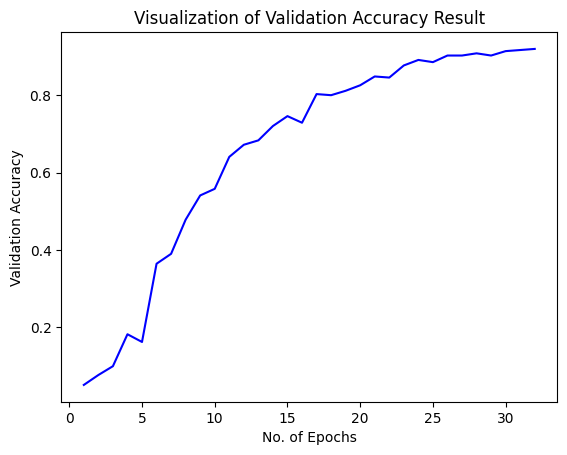

In [77]:

plt.plot(epochs,training_history.history['val_accuracy'],color='blue')
plt.xlabel('No. of Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Visualization of Validation Accuracy Result')
plt.show()

In [78]:
test_set = tf.keras.utils.image_dataset_from_directory(
    'test',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False
)

Found 359 files belonging to 36 classes.


In [79]:
test_loss,test_acc = cnn.evaluate(test_set)
print('Test accuracy:', test_acc)

12/12 [==============================] - 4s 104ms/step - loss: 0.5217 - accuracy: 0.9220
Test accuracy: 0.9220055937767029
